In [83]:

import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model

In [60]:
# load dataset
(train_x, train_y), (test_x, test_y) = keras.datasets.cifar10.load_data()

# normalize to range 0-1
train_x = train_x / 255.0
test_x = test_x / 255.0

val_x = train_x[:5000]
val_y = train_y[:5000]

In [61]:
def id_block(X, f, filters):
   
    X_shortcut = X
    
    X = Conv2D(filters=filters, kernel_size=(1, 1), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    # X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    
    
    X = Conv2D(filters=filters, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    # X = BatchNormalization(axis=3)(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [62]:
 def conv_block(X, f, filters, s=2):
    
    X_shortcut = X

    X = Conv2D(filters=filters, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X)
    # X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=filters, kernel_size=(f, f), strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
    # X = BatchNormalization(axis=3)(X)

    X_shortcut = Conv2D(filters=filters, kernel_size=(1, 1), strides=(s, s), padding='valid', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    # X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# Correction Experiment 3

## assumption 1 : feature extraction end with reduction

### archi 1

In [70]:
def ResNet():
    X_input = X = Input([32, 32, 3])
    X = Conv2D(18, kernel_size=2, strides=2, activation='relu', padding='same')(X)
    X = AveragePooling2D(pool_size=3, strides=1, padding='same')(X)
    X = conv_block(X, 3, 36, 2)
    X = id_block(X, 4, 36)
    X = conv_block(X, 3, 72, 1)
    X = id_block(X, 4, 72)
    X = id_block(X, 7, 72)
    X = conv_block(X, 3, 144 , 2)
    model = Model(inputs=X_input, outputs=X)
    return model

In [6]:
Input = ResNet()
head_model = Input.output
head_model = Flatten()(head_model)
head_model = Dense(500, activation='tanh')(head_model)
head_model = Dense(250, activation='selu')(head_model)
head_model = Dense(100, activation='tanh')(head_model)    
head_model = Dense(50, activation='selu')(head_model)
head_model = Dense(10, activation='softmax')(head_model)
model = Model(inputs=Input.input, outputs=head_model)
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

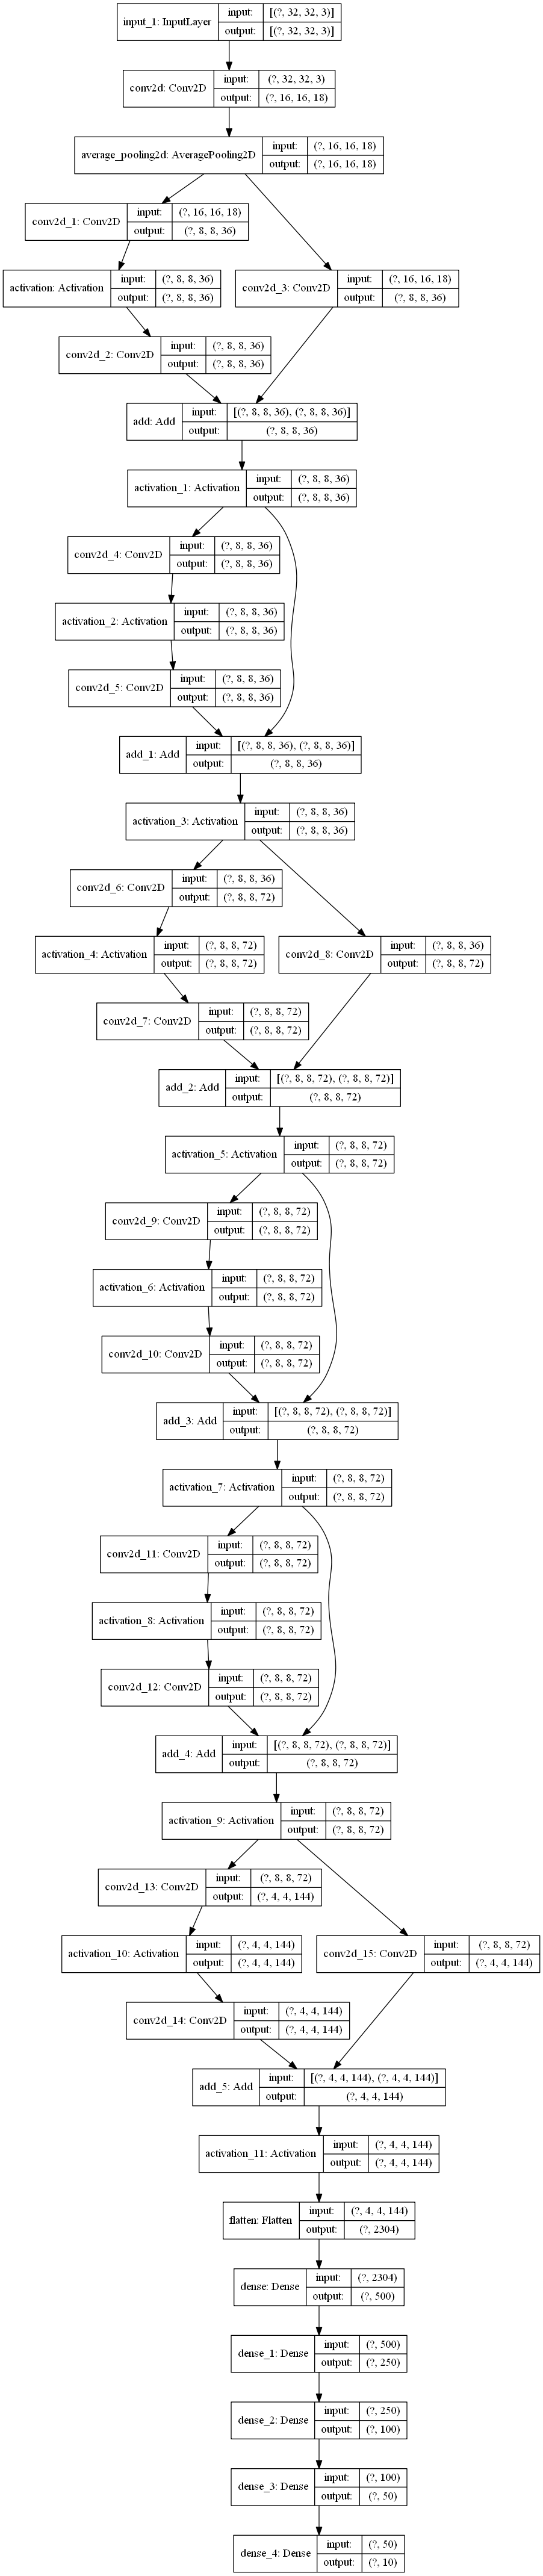

In [7]:
plot_model(model, show_shapes=True)

In [8]:
model.fit(train_x, train_y, epochs=5, validation_data=(val_x, val_y))

Train on 50000 samples, validate on 5000 samples
Epoch 1/5
50000/50000 [==============================] - 111s 2ms/sample - loss: 1.6309 - accuracy: 0.4044 - val_loss: 1.3885 - val_accuracy: 0.4934
Epoch 2/5
50000/50000 [==============================] - 168s 3ms/sample - loss: 1.3731 - accuracy: 0.5060 - val_loss: 1.2330 - val_accuracy: 0.5580
Epoch 3/5
50000/50000 [==============================] - 168s 3ms/sample - loss: 1.2570 - accuracy: 0.5540 - val_loss: 1.1597 - val_accuracy: 0.5958
Epoch 4/5
50000/50000 [==============================] - 169s 3ms/sample - loss: 1.1690 - accuracy: 0.5854 - val_loss: 1.1372 - val_accuracy: 0.5944
Epoch 5/5
50000/50000 [==============================] - 169s 3ms/sample - loss: 1.0936 - accuracy: 0.6154 - val_loss: 0.9686 - val_accuracy: 0.6630


In [9]:
model.evaluate(test_x, test_y)

10000/10000 [==============================] - 11s 1ms/sample - loss: 1.2078 - accuracy: 0.5795


[1.2078063020706176, 0.5795]

In [10]:
model.evaluate(train_x, train_y)

50000/50000 [==============================] - 53s 1ms/sample - loss: 0.9887 - accuracy: 0.6546


[0.9887088064193725, 0.65464]

### archi 7

In [25]:
def ResNet():
    X_input = X = Input([32, 32, 3])
    X = Conv2D(18, kernel_size=6, strides=5, activation='selu', padding='same')(X)
    X = AveragePooling2D(pool_size=3, strides=1, padding='same')(X)
    X = id_block(X, 2, 18)
    X = conv_block(X, 6, 36, 2)
    model = Model(inputs=X_input, outputs=X)
    return model

In [26]:
Input = ResNet()
head_model = Input.output
head_model = Flatten()(head_model)
head_model = Dense(250, activation='selu')(head_model)
head_model = Dense(120, activation='selu')(head_model)
head_model = Dense(60, activation='tanh')(head_model)
head_model = Dense(10, activation='softmax')(head_model)
model = Model(inputs=Input.input, outputs=head_model)
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

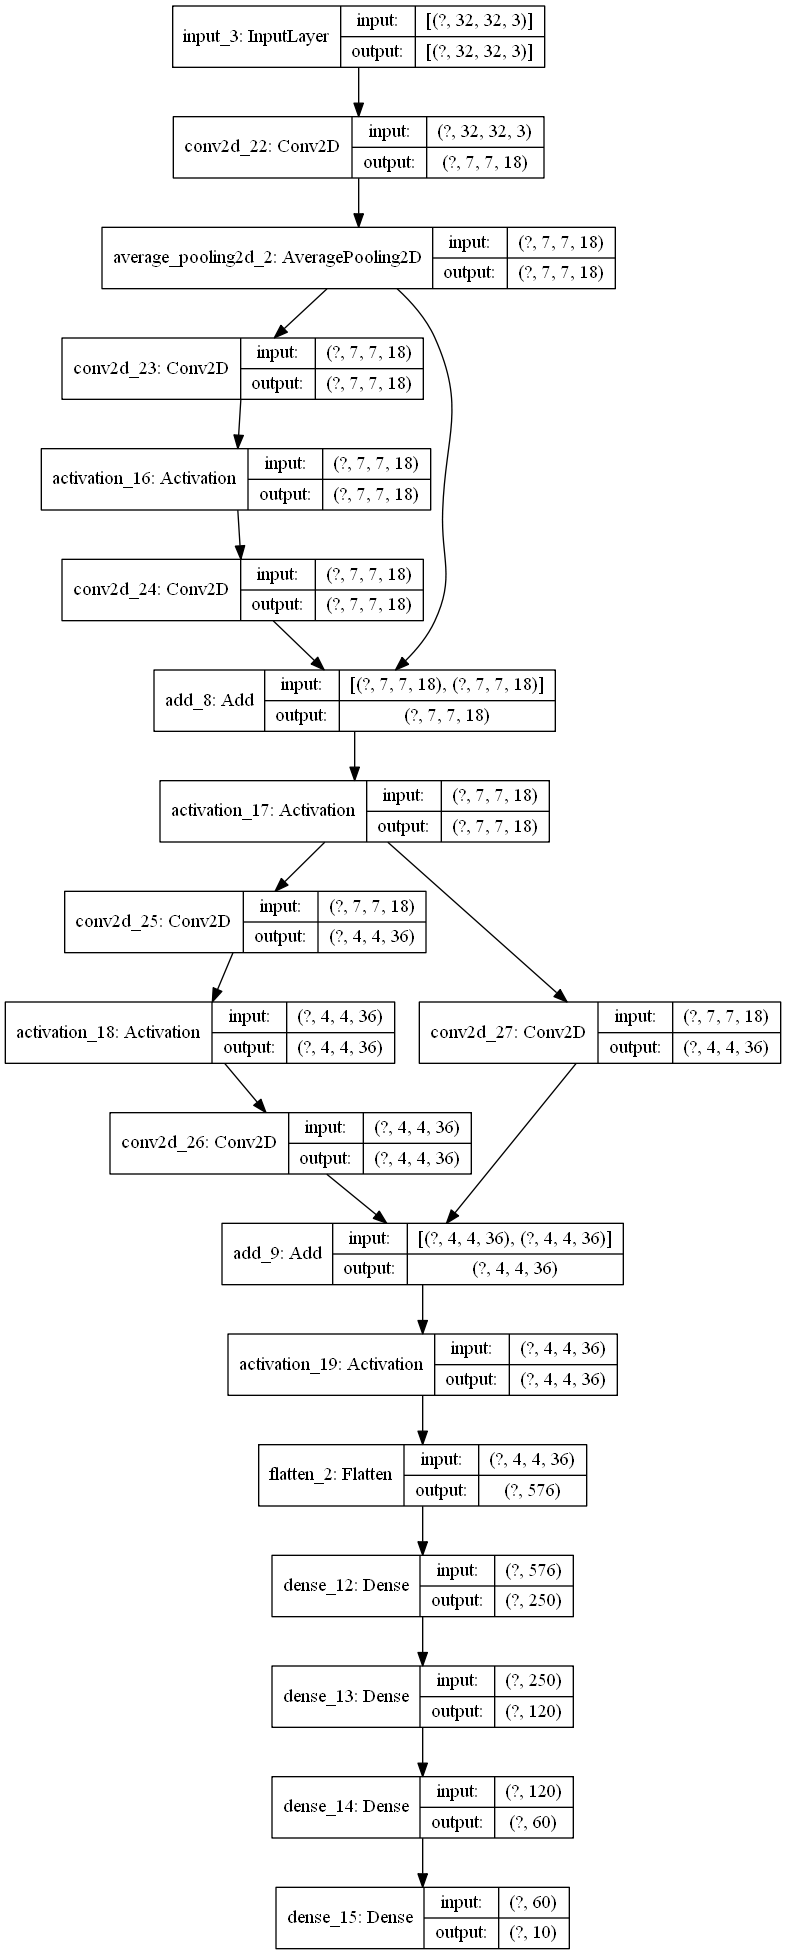

In [27]:
plot_model(model, show_shapes=True)

In [28]:
model.fit(train_x, train_y, epochs=5, validation_data=(val_x, val_y))

Train on 50000 samples, validate on 5000 samples
Epoch 1/5
50000/50000 [==============================] - 30s 607us/sample - loss: 1.7263 - accuracy: 0.3782 - val_loss: 1.5375 - val_accuracy: 0.4484
Epoch 2/5
50000/50000 [==============================] - 30s 602us/sample - loss: 1.5311 - accuracy: 0.4538 - val_loss: 1.4140 - val_accuracy: 0.4892
Epoch 3/5
50000/50000 [==============================] - 30s 606us/sample - loss: 1.4566 - accuracy: 0.4781 - val_loss: 1.3546 - val_accuracy: 0.5142
Epoch 4/5
50000/50000 [==============================] - 31s 610us/sample - loss: 1.4098 - accuracy: 0.4958 - val_loss: 1.3178 - val_accuracy: 0.5350
Epoch 5/5
50000/50000 [==============================] - 31s 613us/sample - loss: 1.3705 - accuracy: 0.5115 - val_loss: 1.2900 - val_accuracy: 0.5498


In [29]:
model.evaluate(test_x, test_y)

10000/10000 [==============================] - 2s 231us/sample - loss: 1.4264 - accuracy: 0.5026


[1.4264014587402343, 0.5026]

In [30]:
model.evaluate(train_x, train_y)

50000/50000 [==============================] - 11s 230us/sample - loss: 1.3226 - accuracy: 0.5324


[1.3225809895324707, 0.53238]

## assumption 2 : kernel <= input/2

### archi 1

In [77]:
def ResNet():
    X_input = X = Input([32, 32, 3])
    X = Conv2D(18, kernel_size=2, strides=2, activation='relu', padding='same')(X)
    X = AveragePooling2D(pool_size=3, strides=1, padding='same')(X)
    X = conv_block(X, 3, 36, 2)
    X = id_block(X, 4, 36)
    X = conv_block(X, 3, 72, 1)
    X = id_block(X, 4, 72)
    X = id_block(X, 7, 72)
    model = Model(inputs=X_input, outputs=X)
    return model

In [78]:
Input = ResNet()
head_model = Input.output
head_model = Flatten()(head_model)
head_model = Dense(1000, activation='tanh')(head_model)
head_model = Dense(250, activation='selu')(head_model)
head_model = Dense(75, activation='tanh')(head_model)
head_model = Dense(10, activation='softmax')(head_model)
model = Model(inputs=Input.input, outputs=head_model)
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

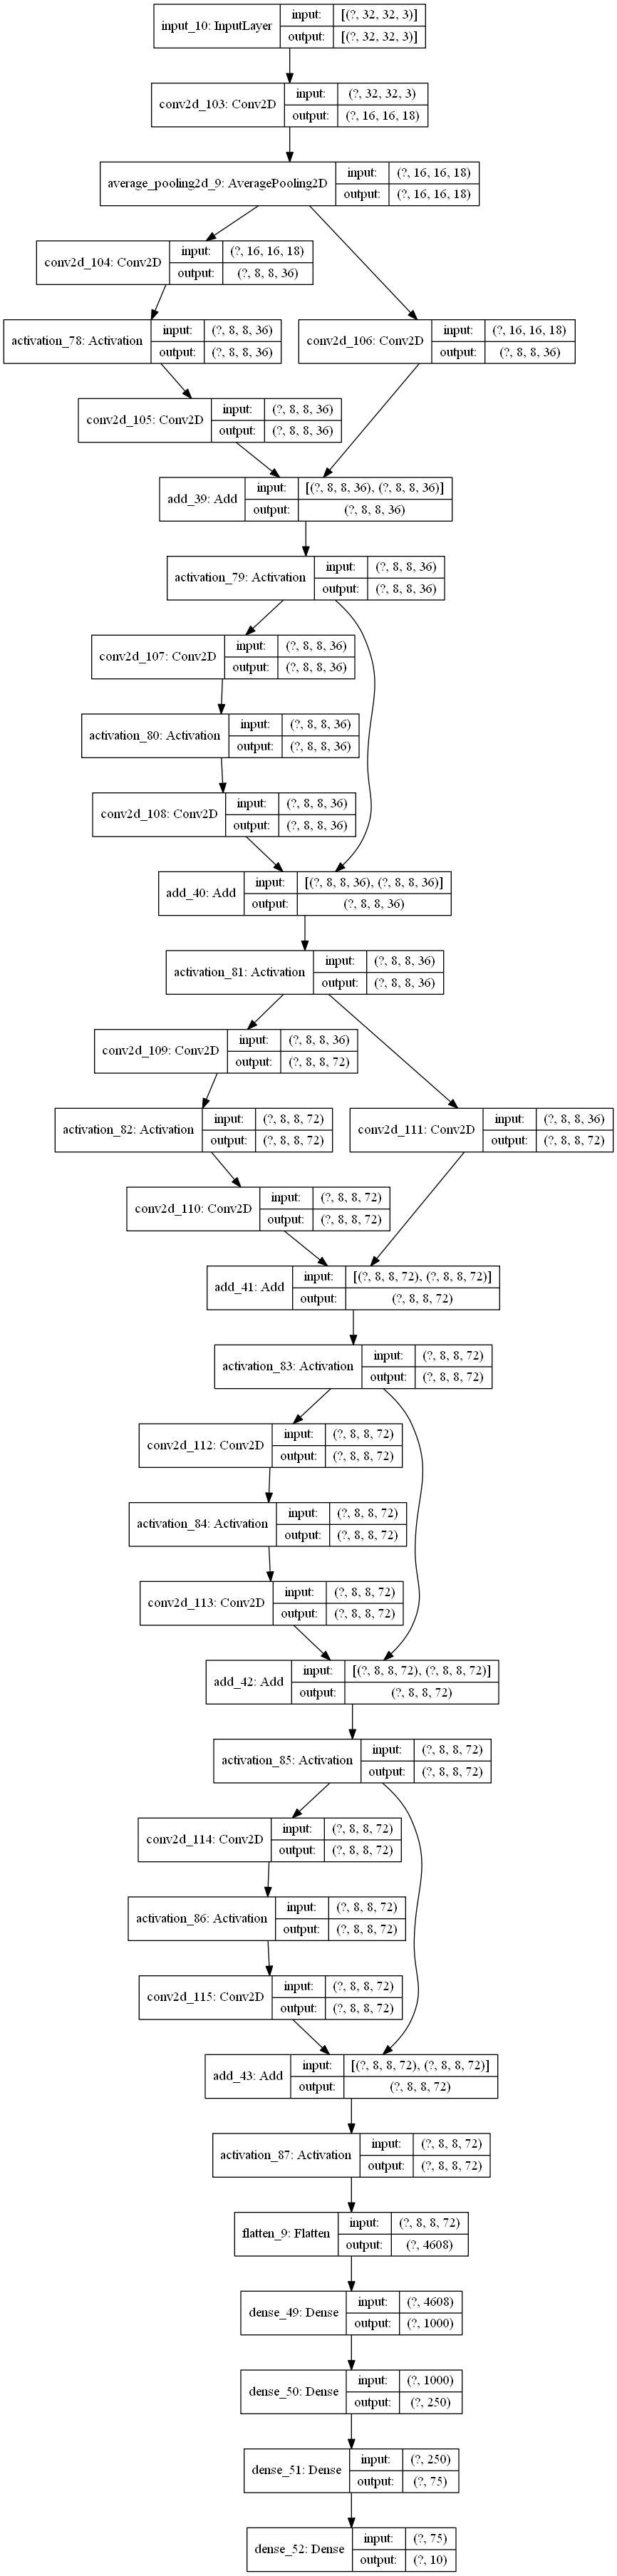

In [79]:
plot_model(model, show_shapes=True)

In [80]:
model.fit(train_x, train_y, epochs=5, validation_data=(val_x, val_y))

Train on 50000 samples, validate on 5000 samples
Epoch 1/5
50000/50000 [==============================] - 77s 2ms/sample - loss: 1.8312 - accuracy: 0.3279 - val_loss: 1.5369 - val_accuracy: 0.4342
Epoch 2/5
50000/50000 [==============================] - 64s 1ms/sample - loss: 1.4810 - accuracy: 0.4662 - val_loss: 1.3580 - val_accuracy: 0.5096
Epoch 3/5
50000/50000 [==============================] - 78s 2ms/sample - loss: 1.3870 - accuracy: 0.5039 - val_loss: 1.3141 - val_accuracy: 0.5256
Epoch 4/5
50000/50000 [==============================] - 92s 2ms/sample - loss: 1.3328 - accuracy: 0.5289 - val_loss: 1.2863 - val_accuracy: 0.5370
Epoch 5/5
50000/50000 [==============================] - 89s 2ms/sample - loss: 1.2911 - accuracy: 0.5421 - val_loss: 1.2686 - val_accuracy: 0.5544


In [81]:
model.evaluate(test_x, test_y)

10000/10000 [==============================] - 2s 208us/sample - loss: 1.3585 - accuracy: 0.5244


[1.3585130191802979, 0.5244]

In [82]:
model.evaluate(train_x, train_y)

50000/50000 [==============================] - 22s 435us/sample - loss: 1.2828 - accuracy: 0.5478


[1.2827632703018188, 0.5478]

### archi 7

In [84]:
def ResNet():
    X_input = X = Input([32, 32, 3])
    X = Conv2D(18, kernel_size=6, strides=5, activation='selu', padding='same')(X)
    X = AveragePooling2D(pool_size=3, strides=1, padding='same')(X)
    X = id_block(X, 2, 18)
    X = conv_block(X, 6, 36, 1)
    model = Model(inputs=X_input, outputs=X)
    return model

In [85]:
Input = ResNet()
head_model = Input.output
head_model = Flatten()(head_model)
head_model = Dense(250, activation='selu')(head_model)
head_model = Dense(75, activation='relu')(head_model)
head_model = Dense(10, activation='softmax')(head_model)
model = Model(inputs=Input.input, outputs=head_model)
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

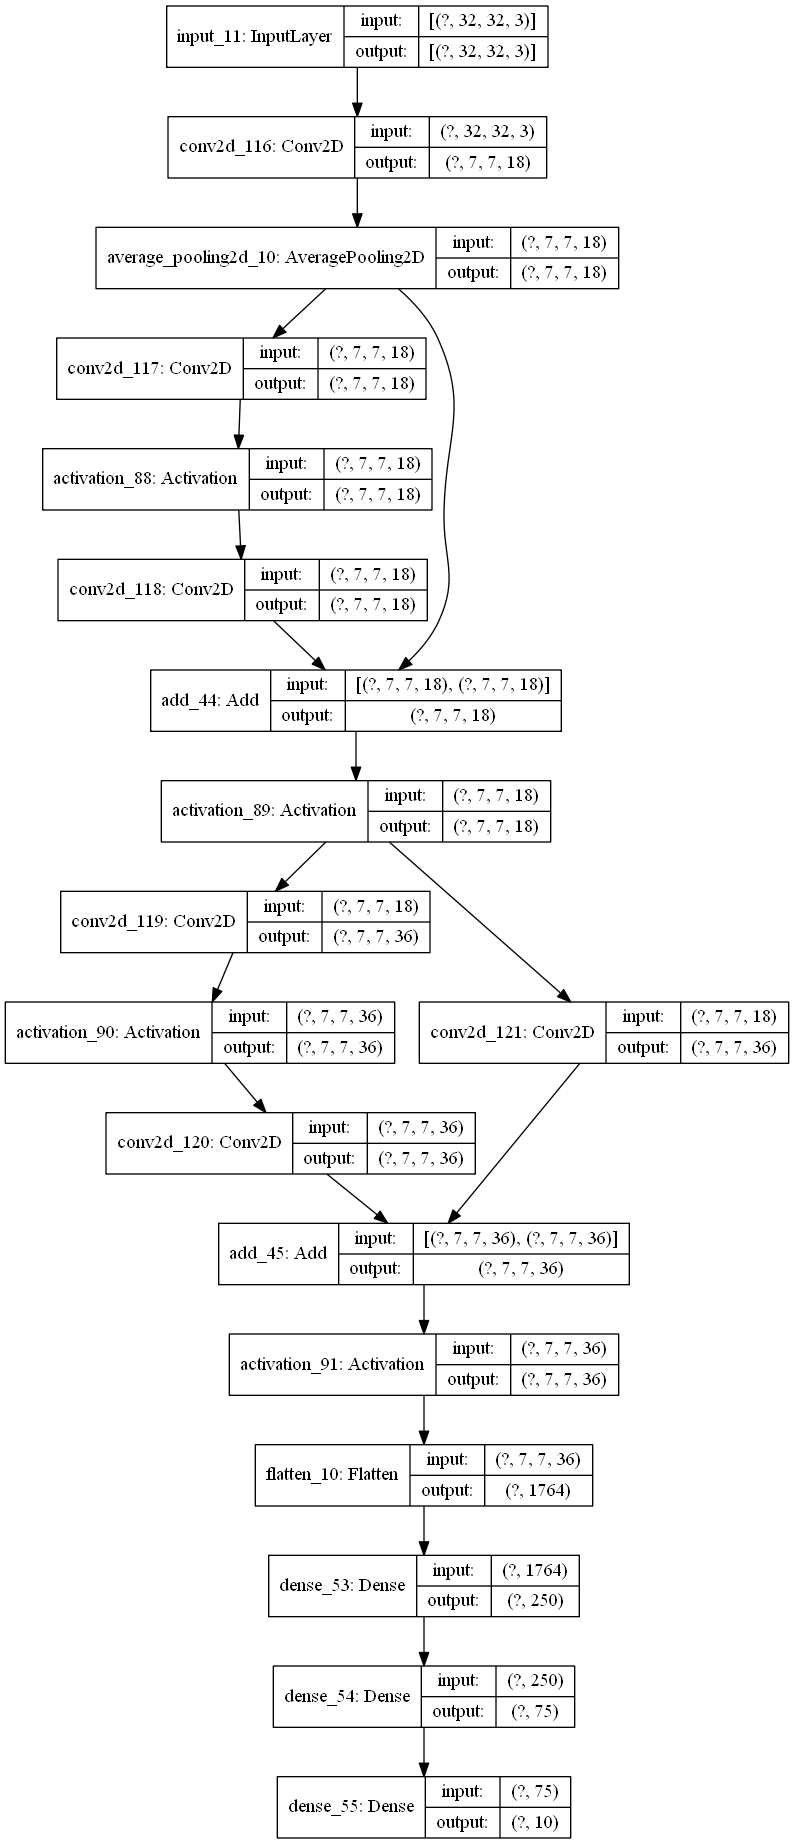

In [86]:
plot_model(model, show_shapes=True)

In [87]:
model.fit(train_x, train_y, epochs=5, validation_data=(val_x, val_y))

Train on 50000 samples, validate on 5000 samples
Epoch 1/5
50000/50000 [==============================] - 12s 236us/sample - loss: 1.7362 - accuracy: 0.3738 - val_loss: 1.5095 - val_accuracy: 0.4534
Epoch 2/5
50000/50000 [==============================] - 12s 235us/sample - loss: 1.5035 - accuracy: 0.4639 - val_loss: 1.3817 - val_accuracy: 0.4984
Epoch 3/5
50000/50000 [==============================] - 16s 321us/sample - loss: 1.4173 - accuracy: 0.4954 - val_loss: 1.3251 - val_accuracy: 0.5376
Epoch 4/5
50000/50000 [==============================] - 14s 272us/sample - loss: 1.3548 - accuracy: 0.5167 - val_loss: 1.2636 - val_accuracy: 0.5520
Epoch 5/5
50000/50000 [==============================] - 29s 589us/sample - loss: 1.3061 - accuracy: 0.5359 - val_loss: 1.1936 - val_accuracy: 0.5788


In [88]:
model.evaluate(test_x, test_y)

10000/10000 [==============================] - 3s 251us/sample - loss: 1.3538 - accuracy: 0.5138


[1.3537944911956787, 0.5138]

In [89]:
model.evaluate(train_x, train_y)

50000/50000 [==============================] - 13s 257us/sample - loss: 1.2156 - accuracy: 0.5618


[1.2156066510391235, 0.5618]